# [Sutton and Barto Notebooks](https://github.com/seungjaeryanlee/sutton-barto-notebooks): Figure 2.2

[모두AI](https://www.modu.ai)  
저자: 이승재  

![Figure 2.2](figure_2_2.png)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def argmax_all(list_):
    """
    주어진 list의 최대값들의 index들을 list 형태로 반환합니다. 첫 최대값의 index만 반환하는
    np.argmax와는 다릅니다.
    """
    return np.argwhere(list_ == list_.max()).flatten()

## Environment

![Figure 2.1](figure_2_1.png)

In [3]:
class Environment:
    """
    Figure 2.1에서 보여진 10개의 행동이 가능한 Bandit입니다.
    """
    def __init__(self, n_actions=10):
        self.action_space = [i for i in range(n_actions)]
        self.distributions = []
        for _ in range(n_actions):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

    def step(self, action):
        """
        주어진 행동에 대한 보상을 반환합니다.
        """
        mean, stddev = self.distributions[action]
        reward = np.random.normal(loc=mean, scale=stddev)
        return reward

    def reset(self):
        """
        환경의 보상 분포들을 재설정합니다.
        """
        self.distributions = []
        for _ in range(len(self.action_space)):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

## Agent

책에 포함된 밴딧 알고리즘을 구현했습니다.  

![](bandit_algorithm.png)

In [4]:
class Agent:
    """
    엡실론 탐욕 에이전트입니다.
    """

    def __init__(self, action_space, epsilon=0):
        self.action_space = action_space
        self.q = np.zeros(len(action_space))
        self.action_counts = np.zeros(len(action_space), dtype=int)
        self.epsilon = epsilon

    def get_action(self):
        """
        엡실론 탐욕 정책으로 행동을 선택합니다.
        """
        if random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            return np.random.choice(argmax_all(self.q))

    def update_q(self, action, reward):
        """
        주어진 행동과 보상으로 Q값을 업데이트합니다.
        """
        self.action_counts[action] += 1
        self.q[action] += (reward - self.q[action]) / \
            self.action_counts[action]

    def reset(self):
        """
        에이전트의 Q값들을 0으로 재설정합니다.
        """
        self.q = np.zeros(len(self.action_space))
        self.sum_rewards = np.zeros(len(self.action_space))
        self.action_counts = np.zeros(len(self.action_space), dtype=int)

## Plots

In [5]:
def run(env, agent, n_steps=1000):
    """
    Bandit 환경에서 n_steps 번 행동을 합니다. 이것을 하나의 '실행'이라 합니다.
    """
    actions = np.zeros(n_steps, dtype=int)
    rewards = np.zeros(n_steps)
    for i in range(n_steps):
        actions[i] = agent.get_action()
        rewards[i] = env.step(actions[i])
        agent.update_q(actions[i], rewards[i])

    return (actions, rewards)

In [6]:
def runs(env, agent, n_runs=2000, n_steps=1000):
    """
    주어진 환경과 에이전트로 여러 번 실행합니다. 각 실행마다 환경과 에이전트는
    초기화됩니다. 환경이 초기화되면 각 행동들의 보상 분포가 바뀌고, 에이전트가
    초기화되면 Q값이 초기화됩니다.
    """
    sum_rewards = np.zeros(n_steps)
    optimal_action_counts = np.zeros(n_steps)

    for i in range(n_runs):
        env.reset()
        agent.reset()

        actions, rewards = run(env, agent, n_steps)

        sum_rewards = np.add(sum_rewards, rewards)

        for step, action in enumerate(actions):
            if action == env.optimal_action:
                optimal_action_counts[step] += 1

    return sum_rewards / n_steps, optimal_action_counts / n_runs

In [7]:
def plot_average_rewards(epsilons, n_runs, n_steps):
    """
    실행들 동안 각 시간 스텝의 평균 보상을 나타내는 그래프를 그립니다.
    """
    plt.xlabel('Steps')
    plt.ylabel('Average reward', rotation='horizontal', ha='right')
    for epsilon in epsilons:
        env = Environment()
        agent = Agent(env.action_space, epsilon=epsilon)
        avg_rewards, _ = runs(env, agent, n_runs, n_steps)
        plt.plot(avg_rewards)

    plt.legend(epsilons)
    # plt.savefig('plot_average_rewards.png')
    plt.show()

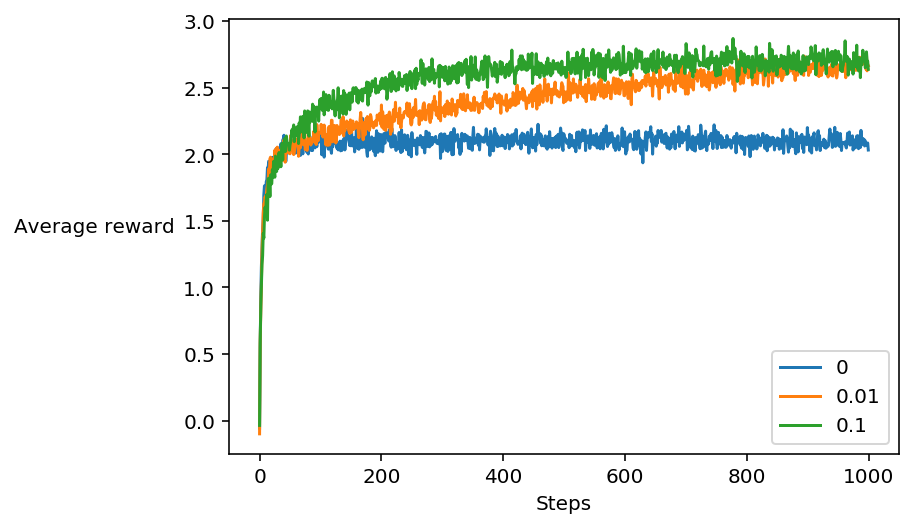

In [8]:
plot_average_rewards([0, 1e-2, 1e-1], n_runs=2000, n_steps=1000)

In [9]:
def plot_optimal_action_percent(epsilons, n_runs, n_steps):
    """
    실행들 동안 평균적으로 최적 행동을 얼마나 많이 하는지 나타내는 그래프를 그립니다. 최적 행동은
    가장 평균값이 높은 보상을 선택하는 것입니다.
    """
    plt.xlabel('Steps')
    plt.ylabel('% Optimal Action', rotation='horizontal', ha='right')
    for epsilon in epsilons:
        env = Environment()
        agent = Agent(env.action_space, epsilon=epsilon)
        _, optimal_action_percent = runs(env, agent, n_runs, n_steps)
        plt.plot(optimal_action_percent)

    plt.legend(epsilons)
    # plt.savefig('plot_optimal_action_percent.png')
    plt.show()

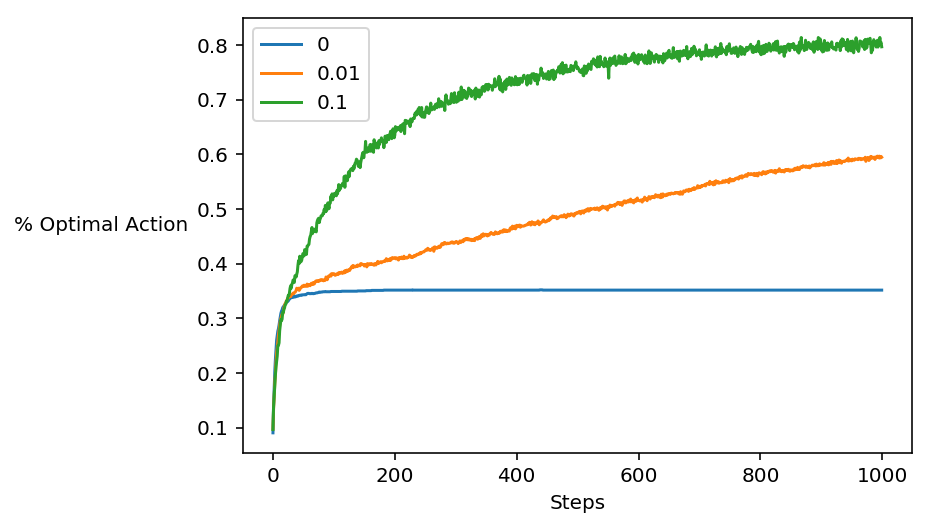

In [10]:
plot_optimal_action_percent([0, 1e-2, 1e-1], n_runs=2000, n_steps=1000)

In [11]:
def plots(epsilons, n_runs, n_steps):
    """
    평균 보상 그래프와 최적 행동 그래프를 그립니다.
    """
    f, axarr = plt.subplots(2, sharex=True)
    f.set_figheight(8)
    f.set_figwidth(6)

    axarr[0].set_xlabel('Steps')
    axarr[0].set_ylabel('Average reward', rotation='horizontal', ha='right')
    axarr[1].set_xlabel('Steps')
    axarr[1].set_ylabel('% Optimal Action', rotation='horizontal', ha='right')
    for epsilon in epsilons:
        env = Environment()
        agent = Agent(env.action_space, epsilon=epsilon)
        avg_rewards, optimal_action_percent = runs(env, agent, n_runs, n_steps)
        axarr[0].plot(avg_rewards)
        axarr[1].plot(optimal_action_percent)

    axarr[0].legend(epsilons)
    axarr[1].legend(epsilons)
    # plt.savefig('plots.png')
    plt.show()

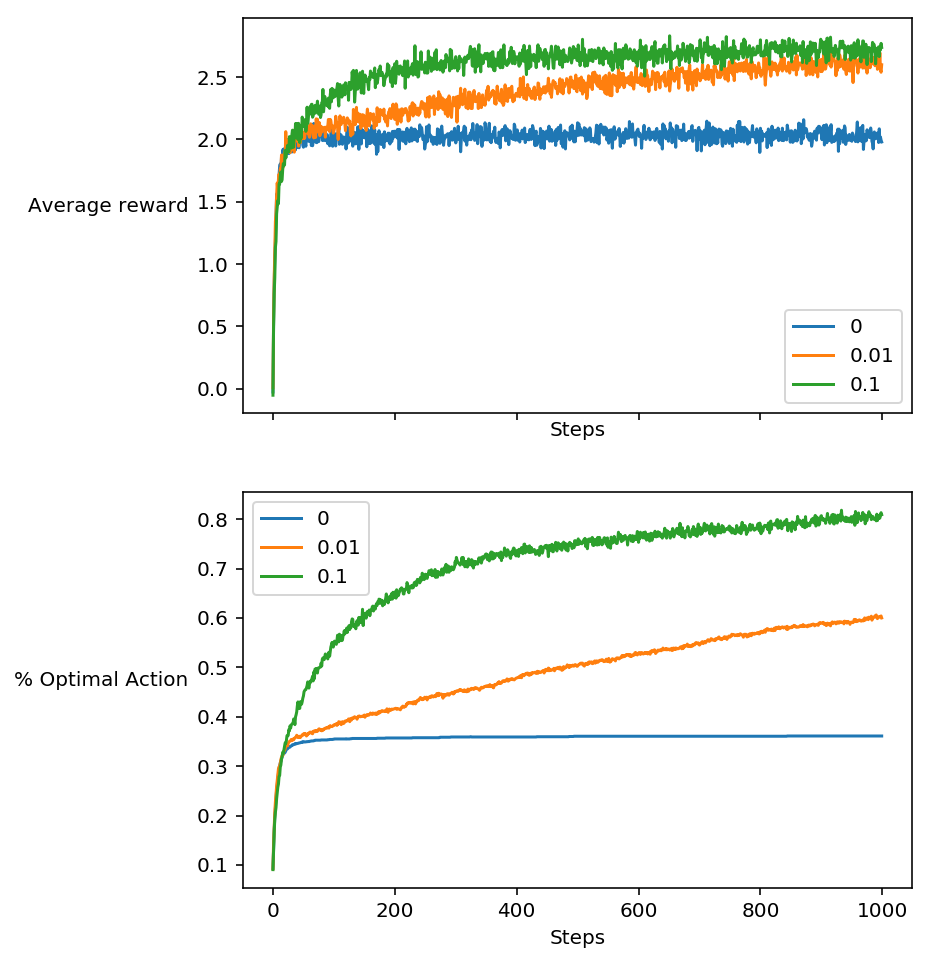

In [12]:
plots([0, 1e-2, 1e-1], n_runs=2000, n_steps=1000)